## Toy Model 1: 2 spatial modes with different oscillating frequencies

### Created by Yuying Liu, 09/23/2019

$$\Phi(x, t) = u(x)cos(\omega_0 t) + v(x)cos(\omega_1 t + \frac{\pi}{4})$$

In [1]:
# imports
import os
import sys
import torch
import torch.nn as nn
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm.notebook import tqdm

module_path = os.path.abspath(os.path.join('../../multiscale_HiTS/src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils
import ResNet as tnet

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import torch_cae_multilevel_V4 as net
from utils_MrCAE import *


## Simulation 

In [2]:
# #make amd save data
# # params
# w0 = 0.5
# w1 = 4.0
# sigma0 = 10.0
# sigma1 = 0.25

# # define two modes
# def phi1(x, y, t):
#     return 1./np.cosh((x+1)/sigma0)/np.cosh((y-1)/sigma0)*np.cos(w0*t)

# def phi2(x, y, t):
#     return 1./(sigma1*np.sqrt(2*np.pi))*np.exp(-((x-1)**2+(y+1)**2)/(2*sigma1**2))*np.cos(w1*t + np.pi/4)

# # mesh grids
# x = np.linspace(-5, 5, 127)
# y = np.linspace(-5, 5, 127)
# t = np.linspace(0, 40*np.pi, 500)
# xgrid, ygrid, tgrid = np.meshgrid(x, y, t)

# # Phi = phi1(xgrid, ygrid, tgrid) + phi2(xgrid, ygrid, tgrid)
# # print(Phi.shape)
# # plt.plot(Phi[0,0])


# # # generate data shape (100,500,127,127)
# n_train = 1
# n_val = 1
# train_data = np.zeros((n_train,500,127,127))
# for i in tqdm(range(n_train)):
#     #t start somewhere between zero and 2 pi
#     start_t = np.random.rand(1) * 2*np.pi
# #     print(start_t)
#     t = np.linspace(0, 40*np.pi, 500) + start_t
#     xgrid, ygrid, tgrid = np.meshgrid(x, y, t)
#     Phi = phi1(xgrid, ygrid, tgrid) + phi2(xgrid, ygrid, tgrid)
#     train_data[i] = Phi.T
    
# print("saving...")
# # np.save('../data/toy1_train_data.npy',train_data)
# val_data = np.zeros((n_val,500,127,127))
# for i in tqdm(range(n_val)):
#     #t start somewhere between zero and 2 pi
#     start_t = np.random.rand(1) * 2*np.pi
#     t = np.linspace(0, 40*np.pi, 500) + start_t
#     xgrid, ygrid, tgrid = np.meshgrid(x, y, t)
#     Phi = phi1(xgrid, ygrid, tgrid) + phi2(xgrid, ygrid, tgrid)
#     val_data[i] = Phi.T
    
# print("saving ...")
# # np.save('../data/toy1_val_data.npy',val_data)
# # scaled_Phi = (Phi - Phi.min()) / (Phi.max() - Phi.min())
# # print(Phi.shape)


# # #normalize 

# train_data = (train_data - train_data.min()) / (train_data.max() - train_data.min())
# print(train_data.shape)
# val_data = (val_data - val_data.min()) / (val_data.max() - val_data.min())

# # np.save(data_path, scaled_Phi.T)

# # np.save('../data/toy1_train_data.npy',train_data)
# # np.save('../data/toy1_val_data.npy',val_data)

## MrCAE

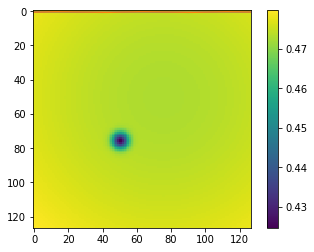

In [3]:
#load data

train_data = np.load('../data/toy1_train_data.npy')
val_data = np.load('../data/toy1_val_data.npy')

plt.plot(train_data[0,:,0,0])
plt.plot(val_data[0,:,0,0])

plt.imshow(train_data[0,0])
plt.colorbar()

Below is the progressive training framework. 
One could have flexible control over each training step: low-level models are cheap to obtain, and higher level models are built based on them -- one can always revert back to the previous level and adjust the parameters to re-train the model if it is not satisfying. 

In [4]:
# init model & load data
data_path = '../data/toy1.npy'
model_path = '../model/toy1_space/'
result_path = '../result/toy1_space/' 

dataset = net.MultiScaleDynamicsDataSet(data_path, n_levels=3)

In [5]:
# # training in space
# archs = [[1,2],[1,2],[1,3]]#,3,4],[1,2,3,4],[1,3,5,7]]
# tols = [ 0.001, 0.0005, 0.0001]
# net.train_net(archs=archs, dataset=dataset, max_epoch=2000, batch_size=350, 
#               tols=tols, activation=torch.nn.Sequential(), w=0.5, model_path=model_path, 
#               result_path=result_path, std=0.01, verbose=2)

In [6]:
# trained models at different levels
models_space = {}
print('model names: model_L{level}_{index}')
for file_name in sorted(os.listdir(model_path)):
    model_name, _ = file_name.split('.')
    print(model_name)
    models_space[model_name] = torch.load(os.path.join(model_path, file_name))

model names: model_L{level}_{index}
model_L0_0
model_L0_0_16
model_L0_0_2
model_L0_0_4
model_L0_0_8
model_L0_1
model_L1_0
model_L1_1
model_L2_0


In [98]:
#define some functions
def obtain_data_at_current_level(data, level,n_levels):
#         train_data = self.data[self.train_inds].to(self.device)
#         val_data = self.data[self.val_inds].to(self.device)
#         test_data = self.data[self.test_inds].to(self.device)
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        for i in range(n_levels - level - 1):
            data = apply_local_op(data.to(device), device, ave=False)

        return data
    
    
def encode(self, x, level, query_in_out_each_level=False, query_hidden=False):
        """
        :param x: a 4D input of NN
        :param level: level index
        :param query_in_out_each_level: if to query the input/output at each level
        (maybe used for enforce losses at different levels)
        :param query_hidden: if to query hidden representations
        :return: output of NN, a list of hidden representations at current level
        """
        # collectors
        all_hidden = dict()
        all_inputs = dict()
        all_outputs = dict()

        # forward prop
        assert level >= 0, print('level index should be a non-negative integer!')
        resolved_maps_dict = self.resolved_maps[str(level)]

        if self.n_filter_groups_each_level['0'] == 1:
            if query_in_out_each_level:
                all_inputs['0'] = x
            encoded = self._modules['L{}_Conv_0'.format(level)](x)

            return encoded
        #else:
        i = self.n_filter_groups_each_level['0']-1
#         print('L{}_Conv_{}'.format(level, i))
        encoded = self._modules['L{}_Conv_{}'.format(level, i)](x)
        if self.use_maps:
            masked_encoded = apply_mask(encoded, resolved_maps_dict[str(i - 1)])
        else:
            masked_encoded = encoded
        return masked_encoded
    
def decode(self, encoded, level, y=None, query_in_out_each_level=False, query_hidden=False):
        """
        :param x: a 4D input of NN
        :param level: level index
        :param query_in_out_each_level: if to query the input/output at each level
        (maybe used for enforce losses at different levels)
        :param query_hidden: if to query hidden representations
        :return: output of NN, a list of hidden representations at current level
        """
        # collectors
        all_hidden = dict()
        all_inputs = dict()
        all_outputs = dict()

        # forward prop
        assert level >= 0, print('level index should be a non-negative integer!')
#         resolved_maps_dict = self.resolved_maps[str(level)]

        if self.n_filter_groups_each_level['0'] == 1:
            if query_hidden:
                all_hidden['L0_0'] = encoded
            # ----- pad -----
            encoded = torch.nn.functional.pad(encoded, (1, 1, 1, 1), 'replicate')
            # ---------------
            y = self._modules['L{}_deConv_0'.format(level)](encoded)
            # chop off the boundaries
            y = y[:, :, 2:-2, 2:-2]
            
            
        else:
            i =self.n_filter_groups_each_level['0'] -1
            y = self._modules['L{}_deConv_{}'.format(level, i)](encoded)
            
        return y

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

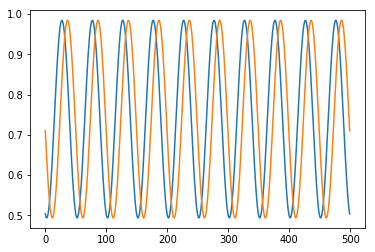

In [8]:
# #encode the data 
model = models_space['model_L0_0']
n_train, n_timesteps, _,_ = train_data.shape
train_encoded = torch.zeros((n_train, n_timesteps, 15,15))
val_encoded = torch.zeros((len(val_data), n_timesteps, 15,15))
data = torch.tensor(train_data).unsqueeze(2).float()

val_data_layer0 = torch.zeros((len(val_data), n_timesteps, 31,31))
for i in tqdm(range(len(train_data))):
    data_this = obtain_data_at_current_level(data[i], 0,3)
    encoded = encode(model, data_this, 0)
    train_encoded[i] = encoded[:,0]

data = torch.tensor(val_data).unsqueeze(2).float()
for i in tqdm(range(len(val_data))):
    data_this = obtain_data_at_current_level(data[i], 0,3)
#     print(data_this.shape)
    val_data_layer0[i] = data_this[:,0]
    encoded = encode(model, data_this, 0)
    val_encoded[i] = encoded[:,0]
    
#plot to make sure they are relatively the same 
plt.plot(val_encoded[1,:,0,0].cpu().detach().numpy())

plt.plot(train_encoded[0,:,0,0].cpu().detach().numpy())

In [9]:
#doing the time training
print("inside train_one_timestep")
i=None
j=None
step_size = 4
dt=1
n_forward = 5
arch = [225, 225*2, 225*2, 225*2, 225]
batch_size = 500
lr = 0.001
# if (i is not None) and (j is not None):
#     model_name = 'model_L{}_D{}_noise{}_i{}_j{}.pt'.format(current_size, step_size, noise, i, j)
# else:
model_name = 'model_L0_0_{}.pt'.format(step_size)#{}_D{}_noise{}.pt'.format(current_size, step_size, noise)
model_path_this = os.path.join(model_path, model_name)

dataset = utils.DataSet(train_encoded.flatten(start_dim=2), val_encoded.flatten(start_dim=2), val_encoded.flatten(start_dim=2), dt, step_size, n_forward)
print('create model {} ...'.format(model_name))
model = tnet.ResNet(arch=arch, dt=dt, step_size=step_size)

# # training
# model.train_net(dataset, max_epoch=30000, batch_size=batch_size, lr=lr,
#             model_path=os.path.join(model_path, model_name))

# # try: #if we already have a model saved
# #     if make_new:
# #         print("Making a new model. Old one deleted. model {}".format(model_name))
# #         assert False
# #     model_time = torch.load(model_path_this)
# #     print("model loaded: ", model_name)
# #     if dont_train: #just load model, no training
# #         print("Model not trained more")
# # #         return model_time
# # except:
# print('create model {} ...'.format(model_path_this))
# model_time = tnet.ResNet(train_data, val_data, step_size,
#                          model_name=model_name, model_dir=model_path, n_inputs=n_inputs,
#                          n_hidden_nodes=20, n_hidden_layers=5, out_dim=15*15,
#                          activation=nn.ReLU(), n_epochs=max_epochs,
#                          threshold=threshold, print_every=print_every,
#                          save_every=save_every)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print("device = ", device)
# model_time.to(device)

# criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model_time.parameters())

# model_time.train_model(optimizer, criterion)

inside train_one_timestep
create model model_L0_0_4.pt ...


/home/kjohnst/multiscale_HiTS/src/utils.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.train_x = torch.tensor(train_data[:, x_idx, :]).float().to(self.device)
/home/kjohnst/multiscale_HiTS/src/utils.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.train_ys = torch.tensor(train_data[:, y_start_idx:y_end_idx:step_size, :]).float().to(self.device)
/home/kjohnst/multiscale_HiTS/src/utils.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.val_x = torch.tensor(val_data[:, x_idx, :]).float().to(self.device)
/home/kjohn

In [24]:
# load models
step_sizes = [2,4,8,16]
models_time = list()
for step_size in step_sizes:
    print('model_L0_0_{}.pt'.format(step_size))
    models_time.append(torch.load(os.path.join(model_path,'model_L0_0_{}.pt'.format(step_size)),map_location='cpu'))
#     models.append(torch.load(os.path.join(model_path, 'model_D{}_noise0.0.pt'.format(step_size)), map_location='cpu'))

# fix model consistencies trained on gpus (optional)
for model in models_time:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()

model_L0_0_2.pt
model_L0_0_4.pt
model_L0_0_8.pt
model_L0_0_16.pt


torch.Size([100, 500, 225])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([100, 500, 15, 15])
torch.Size([100, 225])
False


/home/kjohnst/multiscale_HiTS/src/ResNet.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


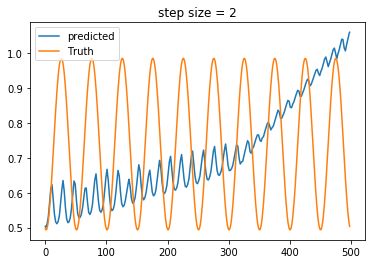

torch.Size([100, 500, 15, 15])
torch.Size([100, 225])
False


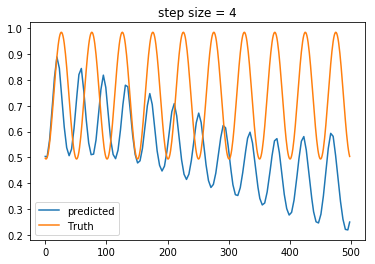

torch.Size([100, 500, 15, 15])
torch.Size([100, 225])
False


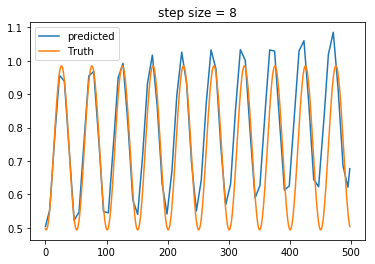

torch.Size([100, 500, 15, 15])
torch.Size([100, 225])
False


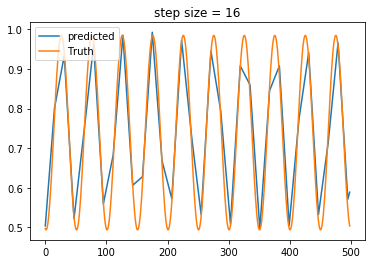

(array([-4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5]),
 <a list of 9 Text yticklabel objects>)

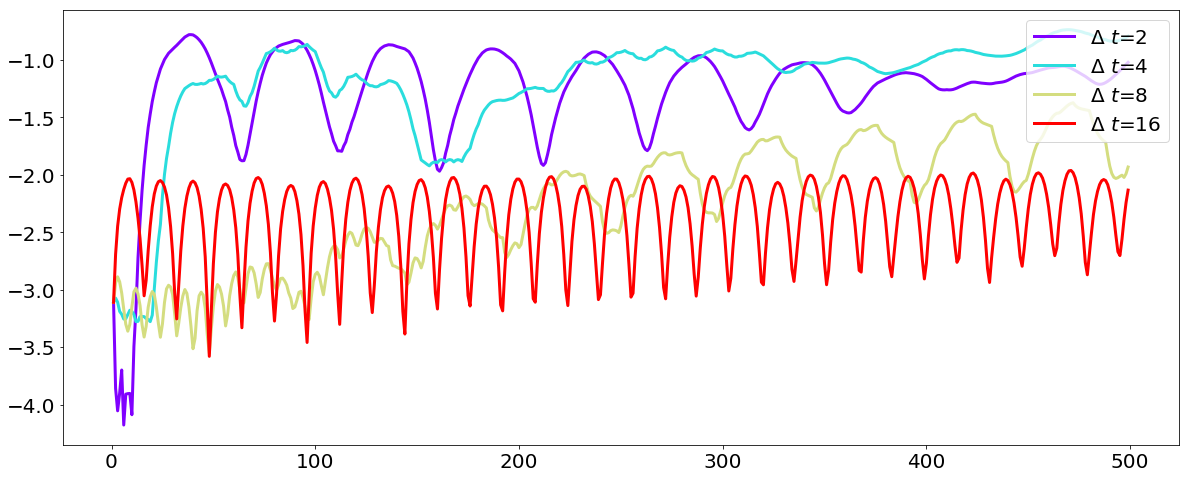

In [25]:
# uniscale time-stepping with NN
preds_mse = list()
times = list()

# test_data = val_data
ks = [1]
n_steps = val_encoded.shape[1] - 1
t = [dt*(step+1) for step in range(n_steps)]
criterion = torch.nn.MSELoss(reduction='none')

test_data = torch.tensor(val_encoded).flatten(start_dim=2).float()
print(test_data.shape)

n_steps = 499
for model in tqdm(models_time):
#     start = time.time()
    print(val_encoded.shape)
    print(val_encoded[:, 0, :].flatten(start_dim=1).float().shape)
    print(torch.tensor(val_encoded[:, 0, :]).flatten(start_dim=1).float().is_cuda)
    y_preds = model.uni_scale_forecast(torch.tensor(val_encoded[:, 0, :]).flatten(start_dim=1).float(), n_steps=n_steps)
#     end = time.time()
#     times.append(end - start)
    preds_mse.append(criterion(torch.tensor(val_encoded[:, 1:, :]).flatten(start_dim=2).float(), y_preds).mean(-1))
    for i in range(1):
        plt.plot(y_preds[1,:,i], label="predicted")
        plt.plot(test_data[1, 1:, i].detach().numpy(),label="Truth")
        x = y_preds[1,::model.step_size,i]
        
#         plt.plot(np.arange(len(x))*model.step_size,x, '.k')
#     plt.xlim([0,200])
    plt.legend()
    plt.title("step size = "+ str(model.step_size))
    plt.show()
    
# visualize forecasting error at each time step    
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(step_sizes))))
for k in range(len(preds_mse)):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.plot(t, np.log10(mean), linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}'.format(step_sizes[k]*dt))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

torch.Size([100, 499, 225])
tensor(140)


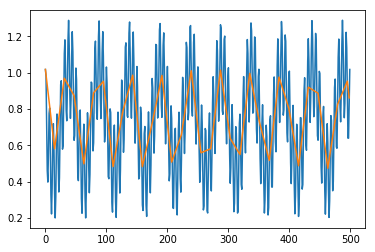

In [26]:
print(y_preds.shape)
print(np.argmax(y_preds[0,0]))
plt.plot(test_data[0,:,140].cpu().detach().numpy())
plt.plot(y_preds[0,:,140])

In [27]:
# model = models_time[0]
#get encoded versions of validation adn training
print(torch.tensor(test_data[:, 0, :]).float().shape)
y_preds = model.uni_scale_forecast(torch.tensor(test_data[:, 0, :]).float(), n_steps=n_steps)
print(test_data.shape)
print(y_preds.shape)
encoded_t1_val = torch.reshape(y_preds, (100,499,15,15))
# print(encoded_t1.shape)
print(val_encoded.shape)

print(torch.tensor(train_encoded[:,0,:]).flatten(start_dim=2).float().shape)
y_preds = model.uni_scale_forecast(torch.tensor(train_encoded[:,0,:]).flatten(start_dim=1).float(), n_steps=n_steps)
print(y_preds.shape)
encoded_t1_train = torch.reshape(y_preds, (len(y_preds),n_steps,15,15))
print(encoded_t1_train.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/home/kjohnst/multiscale_HiTS/src/ResNet.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))


torch.Size([100, 225])
torch.Size([100, 500, 225])
torch.Size([100, 499, 225])
torch.Size([100, 500, 15, 15])
torch.Size([500, 15, 15])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


torch.Size([500, 499, 225])
torch.Size([500, 499, 15, 15])


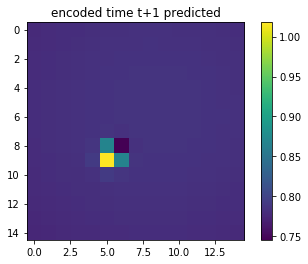

torch.Size([500, 1, 15, 15])


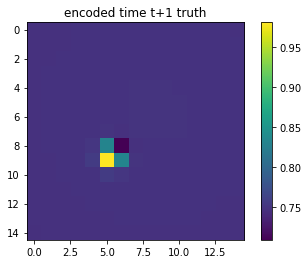

torch.Size([100, 500, 15, 15])
torch.Size([100, 499, 15, 15])


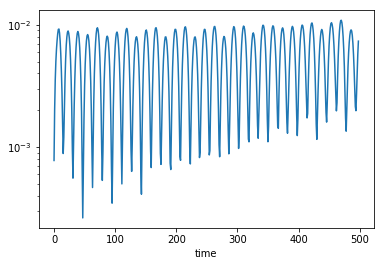

torch.Size([100, 499, 15, 15])
torch.Size([100, 499, 15, 15])


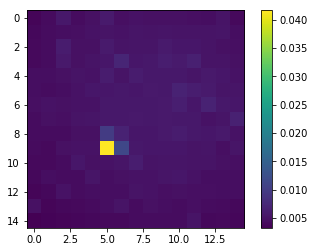

In [28]:
plt.imshow(encoded_t1_val[0,0])
plt.colorbar()
plt.title("encoded time t+1 predicted")
plt.show()

print(encoded.shape)
plt.imshow(val_encoded[0,1].cpu().detach().numpy())
plt.title("encoded time t+1 truth")
plt.colorbar()
plt.show()

print(torch.reshape(val_encoded, (100,500,15,15)).shape)
print(encoded_t1_val.shape)
mse = np.mean(((torch.reshape(val_encoded, (100,500,15,15))[:,1:] - encoded_t1_val)**2).cpu().detach().numpy(), axis=(0,2,3))
plt.xlabel("time")
plt.semilogy(mse)
plt.show()

print(torch.reshape(val_encoded, (100,500,15,15))[:,1:].shape)
print(encoded_t1_val.shape)
mse = np.mean(((torch.reshape(val_encoded, (100,500,15,15))[:,1:] - encoded_t1_val)**2).cpu().detach().numpy(), axis=(0,1))
plt.imshow(mse)
plt.colorbar()
plt.show()

In [29]:
# # trained models at different levels
# models_space = {}
# print('model names: model_L{level}_{index}')
# for file_name in sorted(os.listdir(model_path)):
#     model_name, _ = file_name.split('.')
#     print(model_name)
#     models_space[model_name] = torch.load(os.path.join(model_path, file_name))

In [30]:
# model = models['model_L0_0']
# print(encoded_t1.shape)
# decoded = decode(model, encoded_t1,0)

# #decode the data 
model = models_space['model_L0_0']
print(encoded_t1_train.shape)
n_train, n_timesteps, _,_ = train_data.shape
train_decoded = torch.zeros((n_train, n_timesteps-1, 31,31))
val_decoded = torch.zeros((len(val_data), n_timesteps-1, 31,31))
data = encoded_t1_train.unsqueeze(2).float().to(device)
for i in tqdm(range(len(train_data))):
#     print(data[i].shape)
#     data_this = obtain_data_at_current_level(data[i], 0,3)
    decoded = decode(model, data[i], 0)
    print(decoded.shape)
#     print(train_encoded.shape)
#     print(encoded.shape)
    train_decoded[i] = decoded[:,0]

# data = torch.tensor(val_data).unsqueeze(2).float()
data = encoded_t1_val.unsqueeze(2).float().to(device)
for i in tqdm(range(len(val_data))):
#     print(data[i].shape)
#     data_this = obtain_data_at_current_level(data[i], 0,3)
    decoded = decode(model, data[i], 0)
    val_decoded[i] = decoded[:,0]
    

torch.Size([500, 499, 15, 15])


  0%|          | 0/500 [00:00<?, ?it/s]

torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([49

torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([499, 1, 31, 31])
torch.Size([49

  0%|          | 0/100 [00:00<?, ?it/s]

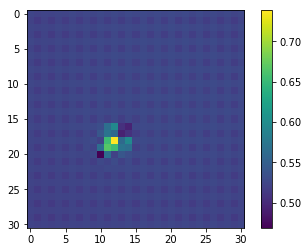

torch.Size([500, 1, 127, 127])


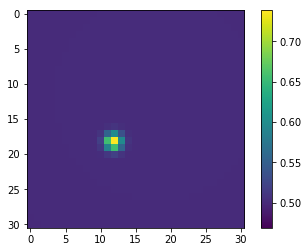

torch.Size([100, 500, 31, 31])
torch.Size([100, 499, 31, 31])


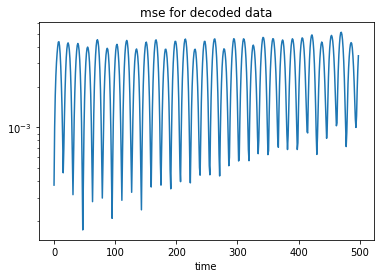

In [36]:
vmin = torch.min(val_decoded[0,0])
vmax = torch.max(val_decoded[0,0])

plt.imshow(val_decoded[0,0].cpu().detach().numpy(), vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

data = torch.tensor(train_data[0]).unsqueeze(1).float()
print(data.shape)
data_this = obtain_data_at_current_level(data, 0,3)
plt.imshow(val_data_layer0[0,1].cpu().detach().numpy(),vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

# print(train_decoded[0].shape)
# print(data_this[1:,0].shape)

print(val_data_layer0.shape)
print(val_decoded.shape)
mse = np.mean(((val_decoded.cpu() - val_data_layer0[:,1:].cpu())**2).cpu().detach().numpy(), axis=(0,2,3))
plt.xlabel("time")
plt.semilogy(mse)
plt.title("mse for decoded data")
plt.show()

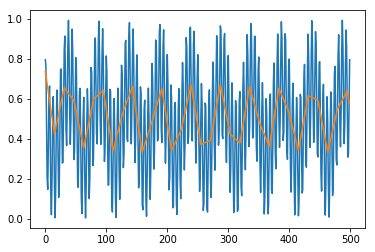

In [196]:
plt.plot(val_data_layer0[0,:,18,12])
plt.plot(val_decoded[0,:,18,12].cpu().detach().numpy())

torch.Size([100, 500, 15, 15])


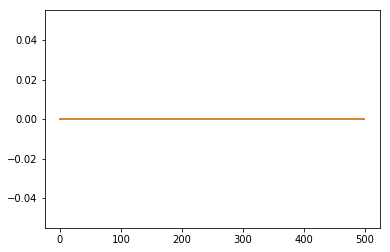

In [101]:
#doing the next step 

# #encode the data 
model = models_space['model_L0_1']
n_train, n_timesteps, _,_ = train_data.shape
train_encoded = torch.zeros((n_train, n_timesteps, 15,15))
val_encoded = torch.zeros((len(val_data), n_timesteps, 15,15))
data = torch.tensor(train_data).unsqueeze(2).float()

val_data_layer0 = torch.zeros((len(val_data), n_timesteps, 31,31))
for i in tqdm(range(len(train_data))):
    data_this = obtain_data_at_current_level(data[i], 0,3)
    plt.plot(data_this[:,0,0,0].cpu().detach().numpy())
    encoded = encode(model, data_this, 0)
    train_encoded[i] = encoded[:,0]
    

data = torch.tensor(val_data).unsqueeze(2).float()
for i in tqdm(range(len(val_data))):
    data_this = obtain_data_at_current_level(data[i], 0,3)
#     print(data_this.shape)
    val_data_layer0[i] = data_this[:,0]
    encoded = encode(model, data_this, 0)
    val_encoded[i] = encoded[:,0]
    
print(val_encoded.shape)
#plot to make sure they are relatively the same 
# plt.plot(val_encoded[0,:,0,0].cpu().detach().numpy())

# plt.plot(train_encoded[0,:,0,0].cpu().detach().numpy())


(array([ 7,  7,  7,  7,  8,  8,  8,  8,  9,  9,  9,  9, 10, 10, 10, 10]), array([4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7]))
tensor([-0.0036, -0.0025, -0.0023, -0.0036, -0.0028,  0.0262,  0.0592, -0.0023,
        -0.0096, -0.1149,  0.0246, -0.0026, -0.0040, -0.0096, -0.0030, -0.0036],
       device='cuda:0', grad_fn=<IndexBackward0>)
torch.Size([16])


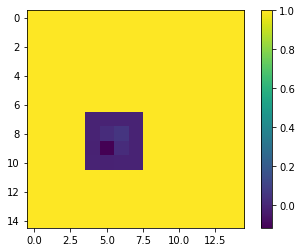

In [102]:
# print(model.resolved_maps['0']['0'])
# plt.imshow(encoded[0,0].cpu().detach().numpy())
# plt.colorbar()

idxs = np.where(encoded[2,0].cpu().detach().numpy()!=0)
print(idxs)
encode_smaller = encoded[0,0][idxs]
print(encode_smaller)
print(encode_smaller.shape)

# plt.imshow(encode_smaller.cpu().detach().numpy().reshape((4,4)))
# plt.colorbar()

ones_arr = torch.ones((15, 15)).to(device)
ones_arr[idxs] = encode_smaller

plt.imshow(ones_arr.cpu().detach().numpy())
plt.colorbar()

# idxs = torch.nonzero(encoded[0,0])
# print(idxs.shape)
# encoded_small = encoded[0,0].cpu().detach().numpy()
# print(encoded_small.shape)
# print(encoded_small[idxs.cpu().detach().numpy()].shape)
# plt.imshow(encoded_small[idxs.cpu().detach().numpy()])

In [115]:
train_encoded_smaller = torch.zeros((n_train, n_timesteps, 16))
idxs = np.where(train_encoded[0,0].cpu().detach().numpy()!=0)

for i in tqdm(range(n_train)):
    for j in range(n_timesteps):
#         print(train_encoded[i,j][idxs].shape)
        train_encoded_smaller[i,j] = train_encoded[i,j][idxs]
    
    
val_encoded_smaller = torch.zeros((len(val_encoded), n_timesteps, 16))

for i in tqdm(range(len(val_encoded_smaller))):
    for j in range(n_timesteps):
#         print(train_encoded[i,j][idxs].shape)
        val_encoded_smaller[i,j] = val_encoded[i,j][idxs]

  0%|          | 0/100 [00:00<?, ?it/s]

6


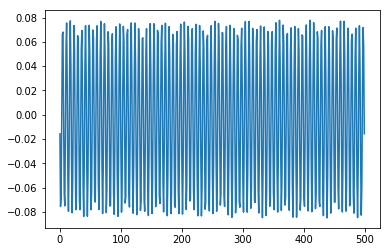

In [191]:
train_encoded_smaller.shape

print(np.argmin(train_encoded_smaller[0,0].cpu().detach().numpy()))
# plt.plot(train_encoded_smaller[0,::4,0].cpu().detach().numpy())
plt.plot(train_encoded_smaller[0,:,6].cpu().detach().numpy())
# plt.xlim([0,50])

In [178]:
#doing the time training
print("inside train_one_timestep")
i=None
j=None
step_size = 8
dt=1
n_forward = 10
arch = [16, 128,128,128, 16]
batch_size = 500
lr = 0.001

model_name = 'model_L0_1_{}.pt'.format(step_size)#{}_D{}_noise{}.pt'.format(current_size, step_size, noise)
model_path_this = os.path.join(model_path, model_name)
print(train_encoded_smaller.shape)
dataset = utils.DataSet(train_encoded_smaller, val_encoded_smaller, val_encoded_smaller, dt, step_size, n_forward)
print('create model {} ...'.format(model_name))
model = tnet.ResNet(arch=arch, dt=dt, step_size=step_size)

# # training
model.train_net(dataset, max_epoch=30000, batch_size=batch_size, lr=lr,
            model_path=os.path.join(model_path, model_name))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

inside train_one_timestep
torch.Size([500, 500, 16])
create model model_L0_1_8.pt ...


/home/kjohnst/multiscale_HiTS/src/utils.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.train_x = torch.tensor(train_data[:, x_idx, :]).float().to(self.device)
/home/kjohnst/multiscale_HiTS/src/utils.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.train_ys = torch.tensor(train_data[:, y_start_idx:y_end_idx:step_size, :]).float().to(self.device)
/home/kjohnst/multiscale_HiTS/src/utils.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.val_x = torch.tensor(val_data[:, x_idx, :]).float().to(self.device)
/home/kjohn

epoch 1000, training loss 0.000893229735083878, validation loss 0.0009014182724058628
(--> new model saved @ epoch 1000)
epoch 2000, training loss 0.00048482941929250956, validation loss 0.0005420228699222207
(--> new model saved @ epoch 2000)
epoch 3000, training loss 0.000471678824396804, validation loss 0.0005306396633386612
(--> new model saved @ epoch 3000)
epoch 4000, training loss 0.00046502240002155304, validation loss 0.0005252595292404294
(--> new model saved @ epoch 4000)
epoch 5000, training loss 0.00046056322753429413, validation loss 0.00052709283772856
epoch 6000, training loss 0.00046837079571560025, validation loss 0.0005230275564827025
(--> new model saved @ epoch 6000)
epoch 7000, training loss 0.0004614089848473668, validation loss 0.0005328108672983944
epoch 8000, training loss 0.0004543629474937916, validation loss 0.0005428229924291372
epoch 9000, training loss 0.0004595071077346802, validation loss 0.000511891907081008
(--> new model saved @ epoch 9000)
epoch 10

KeyboardInterrupt: 

In [179]:
# load models
step_sizes = [8]
models_time = list()
for step_size in step_sizes:
    print('model_L0_1_{}.pt'.format(step_size))
    models_time.append(torch.load(os.path.join(model_path,'model_L0_1_{}.pt'.format(step_size)),map_location='cpu'))
#     models.append(torch.load(os.path.join(model_path, 'model_D{}_noise0.0.pt'.format(step_size)), map_location='cpu'))

# fix model consistencies trained on gpus (optional)
for model in models_time:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()
    


model_L0_1_8.pt


torch.Size([100, 500, 16])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([100, 500, 16])
torch.Size([100, 16])
False


/home/kjohnst/multiscale_HiTS/src/ResNet.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


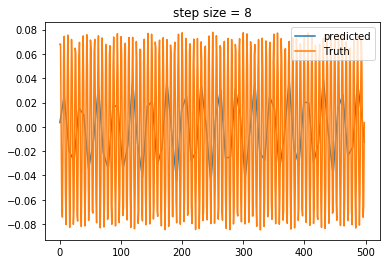

(array([-4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  , -2.75,
        -2.5 ]), <a list of 10 Text yticklabel objects>)

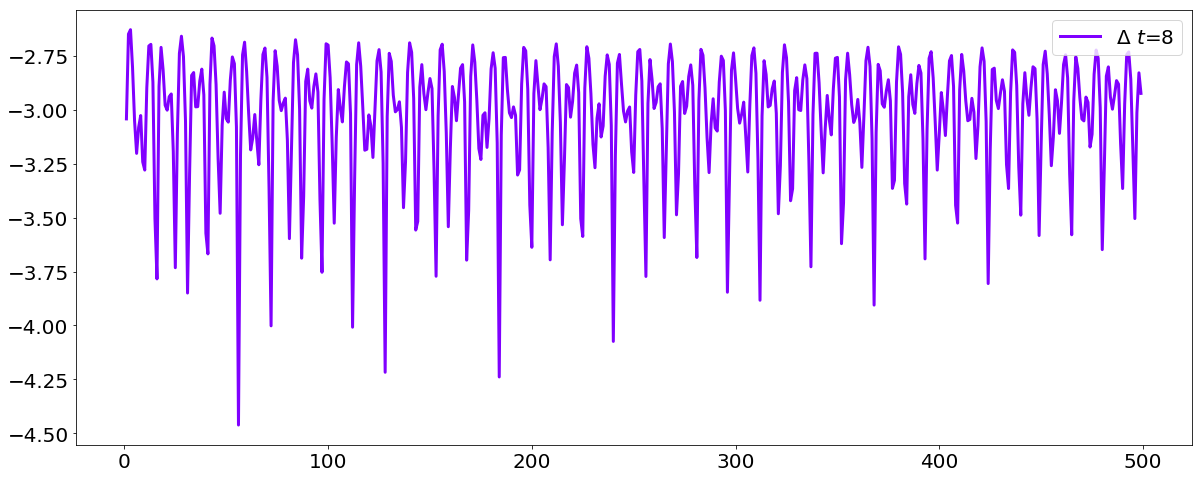

In [190]:
# uniscale time-stepping with NN
preds_mse = list()
times = list()

# test_data = val_data
ks = [1]
n_steps = val_encoded_smaller.shape[1] - 1
t = [dt*(step+1) for step in range(n_steps)]
criterion = torch.nn.MSELoss(reduction='none')

test_data = torch.tensor(val_encoded_smaller).float()
print(test_data.shape)

n_steps = 499
for model in tqdm(models_time):
#     start = time.time()
    print(val_encoded_smaller.shape)
    print(val_encoded_smaller[:, 0, :].float().shape)
    print(torch.tensor(val_encoded_smaller[:, 0, :]).float().is_cuda)
    y_preds = model.uni_scale_forecast(torch.tensor(val_encoded_smaller[:, 0, :]).float(), n_steps=n_steps)
#     end = time.time()
#     times.append(end - start)
    preds_mse.append(criterion(torch.tensor(val_encoded_smaller[:, 1:, :]).float(), y_preds).mean(-1))
    for i in range(6,7):
        plt.plot(y_preds[1,:,i], label="predicted")
        plt.plot(test_data[1, 1:, i].detach().numpy(),label="Truth")
        x = y_preds[1,::model.step_size,i]
        
#         plt.plot(np.arange(len(x))*model.step_size,x, '.k')
#     plt.xlim([0,200])
    plt.legend()
    plt.title("step size = "+ str(model.step_size))
    plt.show()
    
# visualize forecasting error at each time step    
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(step_sizes))))
for k in range(len(preds_mse)):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
    rgb = next(colors)
    plt.plot(t, np.log10(mean), linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}'.format(step_sizes[k]*dt))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

(0, 100)

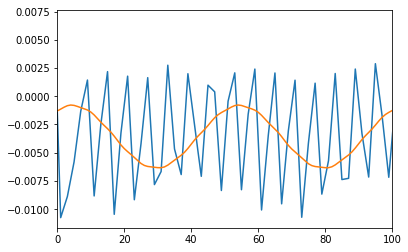

In [165]:
plt.plot(y_preds[3,:,0], label="predicted")
plt.plot(test_data[3, 1:, 0].detach().numpy(),label="Truth")
plt.xlim([0,100])

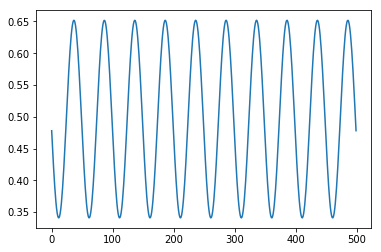

In [39]:
plt.plot(train_data[0,:,0,0])

In [ ]:
class MultiScaleDynamicsDataSet():
    def __init__(self, train_data, val_data, n_levels, map_path=None, train_ratio=0.7, valid_ratio=0.2):
        # load data
#         data = np.load(data_path)
#         self.data = torch.tensor(data).unsqueeze(1).float()
#         #
#         if map_path is not None:
#             map_data = 1 - np.load(map_path)
#             self.map_data = torch.tensor(map_data).float()
#         else:
#             self.map_data = torch.ones(data.shape[-2:]).float()

        self.nt, self.nx, self.ny = data.shape
        # partition
        indices = np.arange(self.nt)
        np.random.shuffle(indices)
        n_train = int(train_ratio*self.nt)
        n_val = int(valid_ratio*self.nt)
        self.n_train = n_train
        self.n_val = n_val
        self.n_test = self.nt - n_train - n_val
        self.train_inds = indices[:n_train]
        self.val_inds = indices[n_train:n_train+n_val]
        self.test_inds = indices[n_train+n_val:]
        #
        self.n_levels = n_levels
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.map_data = self.map_data.to(self.device)
        
        self.train_data = train_data
        self.val_data = val_data

    def obtain_data_at_current_level(self, level):
        train_data = self.train_data#self.data[self.train_inds].to(self.device)
        val_data = self.val_data#self.data[self.val_inds].to(self.device)
        test_data = self.val_data#self.data[self.test_inds].to(self.device)

        for _ in range(self.n_levels - level - 1):
            train_data = apply_local_op(train_data, self.device, ave=False)
            val_data = apply_local_op(val_data, self.device, ave=False)
            test_data = apply_local_op(test_data, self.device, ave=False)

        return train_data, val_data, test_data


In [ ]:
#for next layer, we are going to have val_decoded as input and val_data_layer0 as output

dataset = MultiScaleDynamicsDataSet(data_path, n_levels=3)

# # training in space
archs = [[1,2],[1,2],[1,3]]#,3,4],[1,2,3,4],[1,3,5,7]]
tols = [ 0.001, 0.0005, 0.0001]
net.train_net(archs=archs, dataset=dataset, max_epoch=2000, batch_size=350, 
              tols=tols, activation=torch.nn.Sequential(), w=0.5, model_path=model_path, 
              result_path=result_path, std=0.01, verbose=2)


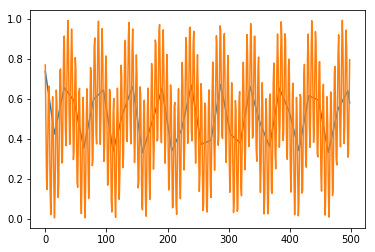

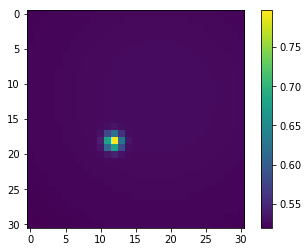

In [32]:
# plt.plot(val_decoded[0,:,12,18].cpu().detach().numpy())
# plt.plot(val_data_layer0[0,1:,12,18].cpu().detach().numpy())

plt.plot(val_decoded[0,:,18,12].cpu().detach().numpy())
plt.plot(val_data_layer0[0,1:,18,12].cpu().detach().numpy())
plt.show()

plt.imshow(val_data_layer0[0,0])
plt.colorbar()


torch.Size([500, 499, 31, 31])
torch.Size([500, 1, 31, 31])
torch.Size([500, 1, 127, 127])


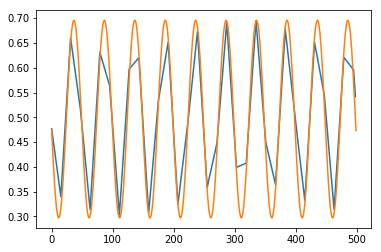

In [33]:
plt.plot(train_decoded[0,:,12,18].cpu().detach().numpy())
print(train_decoded.shape)
print(data_this.shape)
data = torch.tensor(train_data[0]).unsqueeze(1).float()
print(data.shape)
data_this = obtain_data_at_current_level(data, 0,3)
plt.plot(data_this[:,0, 12, 18].cpu().detach().numpy())

In [ ]:
#animate the first decoded

def animate(snapshots, normalize = True, file_name = "animation.gif"):
    """
    Makes an animation of snapshots in time
    
    inputs:
    snapshots: np.array of size (n_time_steps,1, dim, dim)
    normalize = True: whether to fix axis between 0 and 1 or not
    file_name = "animation.gif": file name of where to save gif
    
    outputs:
    no returned output
    gif saved to file_name
    """


    fps = 30
    nSeconds = len(snapshots)/fps
    
    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure( figsize=(8,8) )

    a = snapshots[0,:,:,:][0].T
    if normalize:
        im = plt.imshow(a, interpolation='none', aspect='auto', vmin=0.0, vmax=1.0)
    else:
        im = plt.imshow(a, interpolation='none', aspect='auto', vmin=np.min(snapshots), vmax=np.max(snapshots))
    plt.colorbar()

    print("Animating, may take a little while...")

    def animate_func(i):
        if i % fps == 0:
            print( '.', end ='' )

        im.set_array(snapshots[i,:,:,:,][0].T)
        return [im]

    anim = animation.FuncAnimation(
                                   fig,
                                   animate_func,
                                   frames = int(nSeconds * fps),
                                   interval = 1000 / fps, # in ms
                                   )
    writergif = animation.PillowWriter(fps=30)
    anim.save(file_name, writer=writergif)

    print('Done! gif saved to ', file_name)
    
to_animate = val_decoded[0].unsqueeze(1).cpu().detach().numpy()
animate(to_animate, False, 'decoded_0_0.gif')

In [ ]:
val_decoded[0].unsqueeze(1).shape